# Generic Imports

In [1]:
import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt 

# Setting Up the Environment

In [2]:
from text_snake_simple import TextSnakeEnvSimple

env = TextSnakeEnvSimple(screen_size=(15, 10), colab=True)    
num_runs = 5
x_list = range(num_runs+1)

# Running the Algorithms

## Expected Sarsa

Text Snake!
Score: 22
----------------
[          --| ]
[            | ]
[           |- ]
[           *--]
[           |-|]
[           ||-]
[           |-|]
[   @       ||-]
[           --|]
^^^^^^^^^^^^^^^^
Player Action (Straight)


100%|██████████| 5/5 [01:08<00:00, 13.71s/it]


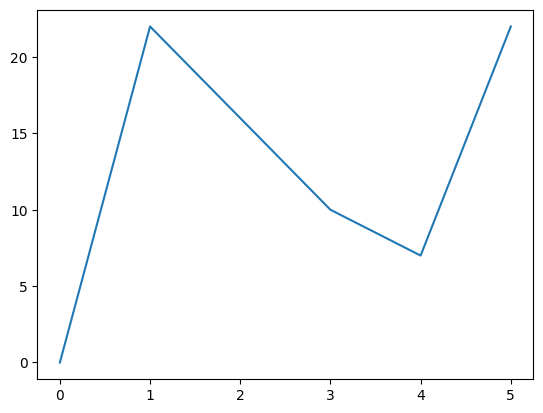

In [3]:
from exp_sarsa_functions.exp_sarsa_utils import create_state_dict, run_episode
from exp_sarsa_functions.exp_sarsa_ag import ExpectedSarsaAgent

state_dict = create_state_dict(n_bools=11)
agent_info = {"num_actions": 3, "num_states": len(state_dict), "EPS_START": 0.9, "EPS_END": 0.05, 
            "EPS_DECAY": 5000, "step_size": 0.8, "discount": 0.99, "seed": 0}
esarsa_agent = ExpectedSarsaAgent()
esarsa_agent.agent_init(agent_info)
esarsa_score_list = [0]
num_episodes = 500
for run in tqdm.tqdm(range(num_runs)):
    steps_done = 0
    for episode in tqdm.tqdm(range(num_episodes)):
        if episode+1 == num_episodes and run+1 == num_runs: 
            steps_done, converged, score = run_episode(env, esarsa_agent, episode, state_dict, steps_done, False, True)
            esarsa_score_list.append(score)
        elif (episode+1)%500 == 0:
            steps_done, converged, score = run_episode(env, esarsa_agent, episode, state_dict, steps_done, False, False)
            esarsa_score_list.append(score)
        else: 
            steps_done, converged, _ = run_episode(env, esarsa_agent, episode, state_dict, steps_done, True, False)
plt.plot(x_list, esarsa_score_list)
plt.show()

## DQN

In [4]:
from dqn_functions.dqn_trainer import QTrainer

qtrainer = QTrainer()
dqn_score_list = [0]
for j in range(num_runs):
    qtrainer.train(env, 500)
    obs, info = env.reset()
    done = False
    n_steps = 0
    while not done and n_steps < 5000:
        prediction = qtrainer.model(torch.tensor(obs, dtype=torch.float))
        action = qtrainer.argmax(prediction).item()
        obs, reward, done, _, info = env.step(action)
        n_steps += 1
        if j+1 == num_runs:
            env.render() 
        if done:
            break
    dqn_score_list.append(info["score"])
    env.close()
plt.plot(x_list, dqn_score_list)
plt.show()

 12%|█▏        | 59/500 [00:09<01:07,  6.49it/s]


KeyboardInterrupt: 

## Policy Estimator

Text Snake!
Score: 0
----------------
[              ]
[              ]
[              ]
[              ]
[            --*
[              ]
[              ]
[          @   ]
[              ]
^^^^^^^^^^^^^^^^
Player Action (Straight)


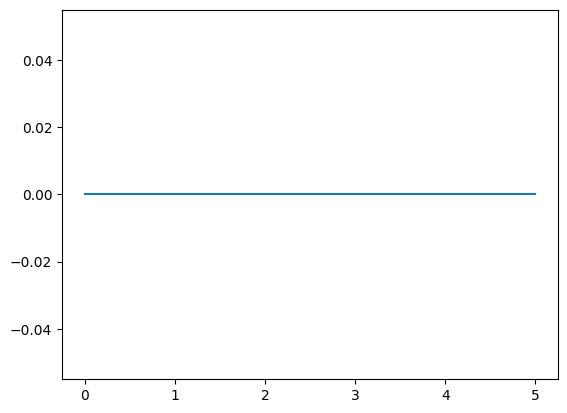

In [5]:
from policy_estimator_functions.policy_estimator import policy_estimator, reinforce, make_greedy_run

state, info = env.reset()
reinf_score_list = [0]
neural_agent = policy_estimator(11, 3)    
optimizer = optim.Adam(neural_agent.network.parameters(), lr=0.0001)
render = False 
for j in tqdm.tqdm(num_runs): 
    num_episodes = 500
    total_rewards, converged = reinforce(env, neural_agent, optimizer, num_episodes=num_episodes)
    if j+1 == num_runs:
        render = True
    converged, score = make_greedy_run(env, neural_agent, render)
    reinf_score_list.append(score)
    env.close()
plt.plot(x_list, reinf_score_list)
plt.show()

## PPO

In [6]:
from stable_baselines3 import PPO

policy_kwargs = dict(activation_fn=nn.ReLU,
                net_arch=dict(pi=[256, 256], vf=[256, 256]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, ent_coef=0.01)
ppo_score_list = [0]
for j in tqdm.tqdm(num_runs):
    model.learn(total_timesteps=500)
    vec_env = model.get_env() 
    obs = vec_env.reset()
    done = False 
    n_step = 0
    while not done and n_step < 5000: 
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        if j+1 == num_runs:
            env.render()
        n_step += 1
        if done: 
            break
    ppo_score_list.append(info[0]["score"])
plt.plot(x_list, ppo_score_list)
plt.show()

Output()

Output()